In [1]:
from keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mibian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from copy import deepcopy
from keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, LeakyReLU, Input, Concatenate, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, TimeDistributed, Dropout, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from numpy.random import seed
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from tensorflow import keras
keras.utils.set_random_seed(812)

C:\Users\unnia\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\unnia\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\unnia\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\unnia\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\3284648654.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data preprocessing

In [2]:
# Read the data
df = pd.read_csv('data.csv')

## TSLA data preprocessing

In [3]:
df_TSLA = df[df['Stock_TSLA'] == 1.0]

# Calculate Simple Moving Average
df_TSLA['SMA'] = df_TSLA['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_TSLA['EMA'] = df_TSLA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_TSLA['RSI'] = RSIIndicator(close=df_TSLA['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_TSLA['UNDERLYING_LAST'], window=20, window_dev=2)
df_TSLA['bb_bbm'] = indicator_bb.bollinger_mavg()
df_TSLA['bb_bbh'] = indicator_bb.bollinger_hband()
df_TSLA['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_TSLA['realized_vol'] = df_TSLA['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_TSLA['C_LAST_lag1'] = df_TSLA['C_LAST'].shift(1)
# For other variables, you could do the same:
df_TSLA['C_IV_lag1'] = df_TSLA['C_IV'].shift(1)


df_TSLA = df_TSLA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate', 'dividend_rate','C_LAST']]
df_TSLA = df_TSLA.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_TSLA[(df_TSLA['C_IV'] == 0) | (df_TSLA['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_TSLA = df_TSLA.drop(indices_to_remove)

# Reset the index
df_TSLA = df_TSLA.reset_index(drop=True)

C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2518326361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA['SMA'] = df_TSLA['UNDERLYING_LAST'].rolling(window=14).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2518326361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA['EMA'] = df_TSLA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2518326361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

## AAPL data preprocessing

In [4]:
df_AAPL = df[df['Stock_AAPL'] == 1.0]

# Calculate Simple Moving Average
df_AAPL['SMA'] = df_AAPL['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_AAPL['EMA'] = df_AAPL['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_AAPL['RSI'] = RSIIndicator(close=df_AAPL['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_AAPL['UNDERLYING_LAST'], window=20, window_dev=2)
df_AAPL['bb_bbm'] = indicator_bb.bollinger_mavg()
df_AAPL['bb_bbh'] = indicator_bb.bollinger_hband()
df_AAPL['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_AAPL['realized_vol'] = df_AAPL['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_AAPL['C_LAST_lag1'] = df_AAPL['C_LAST'].shift(1)
# For other variables, you could do the same:
df_AAPL['C_IV_lag1'] = df_AAPL['C_IV'].shift(1)


df_AAPL = df_AAPL[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate', 'C_LAST']]
df_AAPL = df_AAPL.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_AAPL[(df_AAPL['C_IV'] == 0) | (df_AAPL['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_AAPL = df_AAPL.drop(indices_to_remove)

# Reset the index
df_AAPL = df_AAPL.reset_index(drop=True)

C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2192086726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL['SMA'] = df_AAPL['UNDERLYING_LAST'].rolling(window=14).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2192086726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL['EMA'] = df_AAPL['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2192086726.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

## NVDA data preprocessing

In [5]:
df_NVDA = df[df['Stock_NVDA'] == 1.0]

# Calculate Simple Moving Average
df_NVDA['SMA'] = df_NVDA['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_NVDA['EMA'] = df_NVDA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_NVDA['RSI'] = RSIIndicator(close=df_NVDA['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_NVDA['UNDERLYING_LAST'], window=20, window_dev=2)
df_NVDA['bb_bbm'] = indicator_bb.bollinger_mavg()
df_NVDA['bb_bbh'] = indicator_bb.bollinger_hband()
df_NVDA['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_NVDA['realized_vol'] = df_NVDA['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_NVDA['C_LAST_lag1'] = df_NVDA['C_LAST'].shift(1)
# For other variables, you could do the same:
df_NVDA['C_IV_lag1'] = df_NVDA['C_IV'].shift(1)


df_NVDA = df_NVDA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate', 'C_LAST']]
df_NVDA = df_NVDA.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_NVDA[(df_NVDA['C_IV'] == 0) | (df_NVDA['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_NVDA = df_NVDA.drop(indices_to_remove)

# Reset the index
df_NVDA = df_NVDA.reset_index(drop=True)

C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\1211373322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA['SMA'] = df_NVDA['UNDERLYING_LAST'].rolling(window=14).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\1211373322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA['EMA'] = df_NVDA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\1211373322.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

### Features

In [6]:
# Select features to use for prediction
features = ['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol', 'UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']
target = 'C_LAST'

### Early Stopping

In [7]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation set loss
                               patience=10,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,           # Output a message for each epoch where the training stops
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity

# Subset Data for MNN

In [8]:
# Define the moneyness thresholds
itm_threshold = 0.03  # In-the-money threshold
otm_threshold = -0.03  # Out-of-the-money threshold

## Subset TSLA Data

In [9]:
# Split data into train and test
train_size_TSLA = int(len(df_TSLA) * 0.8)
df_TSLA_train, df_TSLA_test = df_TSLA[:train_size_TSLA], df_TSLA[train_size_TSLA:]

# Calculate the percentage distance from the underlying price to the strike price
df_TSLA_train['PERCENT_DISTANCE'] = (df_TSLA_train['UNDERLYING_LAST'] - df_TSLA_train['STRIKE']) / df_TSLA_train['STRIKE']

# Create subsets based on moneyness
itm_options_TSLA = df_TSLA_train[df_TSLA_train['PERCENT_DISTANCE'] > itm_threshold]  # More than 3% above the strike price
atm_options_TSLA = df_TSLA_train[(df_TSLA_train['PERCENT_DISTANCE'] <= itm_threshold) & (df_TSLA_train['PERCENT_DISTANCE'] >= otm_threshold)]  # Within +/-3%
otm_options_TSLA = df_TSLA_train[df_TSLA_train['PERCENT_DISTANCE'] < otm_threshold]  # More than 3% below the strike price

# Prepare the data for each subset
X_itm_TSLA = itm_options_TSLA[features]
y_itm_TSLA = itm_options_TSLA[target]
X_atm_TSLA = atm_options_TSLA[features]
y_atm_TSLA = atm_options_TSLA[target]
X_otm_TSLA = otm_options_TSLA[features]
y_otm_TSLA = otm_options_TSLA[target]

# Initialize Scalar
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features for ITM options
X_itm_TSLA_scaled = scaler.fit_transform(X_itm_TSLA)
# Scale the features for ATM options
X_atm_TSLA_scaled = scaler.fit_transform(X_atm_TSLA)
# Scale the features for OTM options
X_otm_TSLA_scaled = scaler.fit_transform(X_otm_TSLA)

C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\2325937892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA_train['PERCENT_DISTANCE'] = (df_TSLA_train['UNDERLYING_LAST'] - df_TSLA_train['STRIKE']) / df_TSLA_train['STRIKE']


## Subset AAPL Data

In [10]:
# Split data into train and test
train_size_AAPL = int(len(df_AAPL) * 0.8)
df_AAPL_train, df_AAPL_test = df_AAPL[:train_size_AAPL], df_AAPL[train_size_AAPL:]

# Calculate the percentage distance from the underlying price to the strike price
df_AAPL_train['PERCENT_DISTANCE'] = (df_AAPL_train['UNDERLYING_LAST'] - df_AAPL_train['STRIKE']) / df_AAPL_train['STRIKE']

# Create subsets based on moneyness
itm_options_AAPL = df_AAPL_train[df_AAPL_train['PERCENT_DISTANCE'] > itm_threshold]  # More than 3% above the strike price
atm_options_AAPL = df_AAPL_train[(df_AAPL_train['PERCENT_DISTANCE'] <= itm_threshold) & (df_AAPL_train['PERCENT_DISTANCE'] >= otm_threshold)]  # Within +/-3%
otm_options_AAPL = df_AAPL_train[df_AAPL_train['PERCENT_DISTANCE'] < otm_threshold]  # More than 3% below the strike price

# Prepare the data for each subset
X_itm_AAPL = itm_options_AAPL[features]
y_itm_AAPL = itm_options_AAPL[target]
X_atm_AAPL = atm_options_AAPL[features]
y_atm_AAPL = atm_options_AAPL[target]
X_otm_AAPL = otm_options_AAPL[features]
y_otm_AAPL = otm_options_AAPL[target]


# Initialize Scalar
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features for ITM options
X_itm_AAPL_scaled = scaler.fit_transform(X_itm_AAPL)
# Scale the features for ATM options
X_atm_AAPL_scaled = scaler.fit_transform(X_atm_AAPL)
# Scale the features for OTM options
X_otm_AAPL_scaled = scaler.fit_transform(X_otm_AAPL)

C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\1823318902.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL_train['PERCENT_DISTANCE'] = (df_AAPL_train['UNDERLYING_LAST'] - df_AAPL_train['STRIKE']) / df_AAPL_train['STRIKE']


## Subset NVDA Data

In [11]:
# Split data into train and test
train_size_NVDA = int(len(df_NVDA) * 0.8)
df_NVDA_train, df_NVDA_test = df_NVDA[:train_size_NVDA], df_NVDA[train_size_NVDA:]

# Calculate the percentage distance from the underlying price to the strike price
df_NVDA_train['PERCENT_DISTANCE'] = (df_NVDA_train['UNDERLYING_LAST'] - df_NVDA_train['STRIKE']) / df_NVDA_train['STRIKE']

# Create subsets based on moneyness
itm_options_NVDA = df_NVDA_train[df_NVDA_train['PERCENT_DISTANCE'] > itm_threshold]  # More than 3% above the strike price
atm_options_NVDA = df_NVDA_train[(df_NVDA_train['PERCENT_DISTANCE'] <= itm_threshold) & (df_NVDA_train['PERCENT_DISTANCE'] >= otm_threshold)]  # Within +/-3%
otm_options_NVDA = df_NVDA_train[df_NVDA_train['PERCENT_DISTANCE'] < otm_threshold]  # More than 3% below the strike price

# Prepare the data for each subset
X_itm_NVDA = itm_options_NVDA[features]
y_itm_NVDA = itm_options_NVDA[target]
X_atm_NVDA = atm_options_NVDA[features]
y_atm_NVDA = atm_options_NVDA[target]
X_otm_NVDA = otm_options_NVDA[features]
y_otm_NVDA = otm_options_NVDA[target]

# Initialize Scalar
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features for ITM options
X_itm_NVDA_scaled = scaler.fit_transform(X_itm_NVDA)
# Scale the features for ATM options
X_atm_NVDA_scaled = scaler.fit_transform(X_atm_NVDA)
# Scale the features for OTM options
X_otm_NVDA_scaled = scaler.fit_transform(X_otm_NVDA)

C:\Users\unnia\AppData\Local\Temp\ipykernel_98176\3625806300.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA_train['PERCENT_DISTANCE'] = (df_NVDA_train['UNDERLYING_LAST'] - df_NVDA_train['STRIKE']) / df_NVDA_train['STRIKE']


# Hyperparameter Tuning

In [12]:
def create_module(input_shape, neurons_per_layer, num_layers, activation, l2_reg=0.01):
    input_layer = Input(shape=input_shape)
    hidden_layer = input_layer
    
    for i in range(num_layers):
        hidden_layer = Dense(neurons_per_layer[i], activation=activation, kernel_regularizer=l2(l2_reg))(hidden_layer)
    
    output_layer = Dense(1, activation='linear')(hidden_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [13]:
# Possible hyperparameters
neurons_options = [[64], [128], [64, 64], [128, 128], [64, 128, 64], [128, 128, 128]]
activation_options = ['relu', 'elu']
num_layers_options = [1, 2, 3]
learning_rate = 0.001

scaler = MinMaxScaler()
X_train_TSLA, X_test_TSLA = df_TSLA_train[features], df_TSLA_test[features]
y_train_TSLA, y_test_TSLA = df_TSLA_train[target], df_TSLA_test[target]

X_train_TSLA_scaled = scaler.fit_transform(X_train_TSLA)
X_test_TSLA_scaled = scaler.transform(X_test_TSLA)

# Keep track of experiments
experiment_log = []

input_shape = (len(features),)  # Expects the number of features

# Hyperparameter tuning loop
for neurons_per_layer in neurons_options:
    for activation in activation_options:
        num_layers = len(neurons_per_layer)
        # Create sub-models for each moneyness category
        module_itm = create_module(input_shape, neurons_per_layer, num_layers, activation)
        module_atm = create_module(input_shape, neurons_per_layer, num_layers, activation)
        module_otm = create_module(input_shape, neurons_per_layer, num_layers, activation)

        # Compile each module
        module_itm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
        module_atm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
        module_otm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
        
        # Train each module on its respective subset
        history_itm = module_itm.fit(X_itm_TSLA_scaled, y_itm_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
        history_atm = module_atm.fit(X_atm_TSLA_scaled, y_atm_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
        history_otm = module_otm.fit(X_otm_TSLA_scaled, y_otm_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
        
        # Get the best validation loss from each module training history
        val_loss_itm = min(history_itm.history['val_loss'])
        val_loss_atm = min(history_atm.history['val_loss'])
        val_loss_otm = min(history_otm.history['val_loss'])

        # Define the combined model
        input_layer = Input(shape=input_shape)
        output_itm = module_itm(input_layer)
        output_atm = module_atm(input_layer)
        output_otm = module_otm(input_layer)

        combined_output = Concatenate()([output_itm, output_atm, output_otm])
        final_output = Dense(1, activation='linear')(combined_output)
        combined_model = Model(inputs=input_layer, outputs=final_output)

        # Compile the combined model
        combined_model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

        # Fit the combined model to the full dataset (or a representative training set)
        history_combined = combined_model.fit(X_train_TSLA_scaled, y_train_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
        
        # Get the best validation loss from the combined model training history
        val_loss_combined = min(history_combined.history['val_loss'])

        # Log the experiment results
        experiment_log.append({
            'neurons_per_layer': neurons_per_layer,
            'num_layers': num_layers,
            'activation': activation,
            'learning_rate': learning_rate,
            'val_loss_itm': val_loss_itm,
            'val_loss_atm': val_loss_atm,
            'val_loss_otm': val_loss_otm,
            'val_loss_combined': val_loss_combined
        })

Epoch 1/50
3084/3084 [==============================] - 10s 3ms/step - loss: 1175.6766 - val_loss: 555.2305
Epoch 2/50
3084/3084 [==============================] - 9s 3ms/step - loss: 291.9632 - val_loss: 510.4247
Epoch 3/50
3084/3084 [==============================] - 10s 3ms/step - loss: 286.2552 - val_loss: 499.8477
Epoch 4/50
3084/3084 [==============================] - 10s 3ms/step - loss: 285.1679 - val_loss: 515.7908
Epoch 5/50
3084/3084 [==============================] - 9s 3ms/step - loss: 284.6495 - val_loss: 482.2440
Epoch 6/50
3084/3084 [==============================] - 9s 3ms/step - loss: 284.6154 - val_loss: 496.6395
Epoch 7/50
3084/3084 [==============================] - 9s 3ms/step - loss: 284.0229 - val_loss: 545.2126
Epoch 8/50
3084/3084 [==============================] - 8s 3ms/step - loss: 283.5327 - val_loss: 493.7984
Epoch 9/50
3084/3084 [==============================] - 10s 3ms/step - loss: 283.5952 - val_loss: 508.3944
Epoch 10/50
3084/3084 [==================

4377/4377 [==============================] - 12s 3ms/step - loss: 1.8616 - val_loss: 2.3114
Epoch 10/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.8430 - val_loss: 2.0832
Epoch 11/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.8248 - val_loss: 2.1679
Epoch 12/50
4377/4377 [==============================] - 15s 3ms/step - loss: 1.8082 - val_loss: 2.1140
Epoch 13/50
4377/4377 [==============================] - 11s 2ms/step - loss: 1.7893 - val_loss: 2.1023
Epoch 14/50
4377/4377 [==============================] - 11s 2ms/step - loss: 1.7791 - val_loss: 2.3833
Epoch 15/50
4377/4377 [==============================] - 11s 2ms/step - loss: 1.7650 - val_loss: 2.0450
Epoch 16/50
4377/4377 [==============================] - 11s 3ms/step - loss: 1.7628 - val_loss: 2.0981
Epoch 17/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.7475 - val_loss: 2.1370
Epoch 18/50
4377/4377 [==============================] - 12s 3ms/step - loss

3084/3084 [==============================] - 8s 2ms/step - loss: 286.9341 - val_loss: 530.0369
Epoch 16/50
3084/3084 [==============================] - 7s 2ms/step - loss: 286.8108 - val_loss: 544.6476
Epoch 17/50
3084/3084 [==============================] - 7s 2ms/step - loss: 286.6615 - val_loss: 502.5538
Epoch 18/50
3084/3084 [==============================] - 8s 3ms/step - loss: 286.4080 - val_loss: 515.4725
Epoch 19/50
3084/3084 [==============================] - 8s 2ms/step - loss: 286.3599 - val_loss: 487.9455
Epoch 20/50
3084/3084 [==============================] - 8s 2ms/step - loss: 286.2811 - val_loss: 526.5430
Epoch 21/50
3084/3084 [==============================] - 8s 3ms/step - loss: 286.4068 - val_loss: 504.0548
Epoch 22/50
3084/3084 [==============================] - 7s 2ms/step - loss: 286.0635 - val_loss: 524.0925
Epoch 22: early stopping
Epoch 1/50
280/280 [==============================] - 2s 3ms/step - loss: 485.2016 - val_loss: 356.8409
Epoch 2/50
280/280 [=======

4377/4377 [==============================] - 11s 2ms/step - loss: 2.2948 - val_loss: 4.3502
Epoch 22/50
4377/4377 [==============================] - 11s 2ms/step - loss: 2.3011 - val_loss: 2.7273
Epoch 23/50
4377/4377 [==============================] - 11s 3ms/step - loss: 2.3182 - val_loss: 2.6485
Epoch 24/50
4377/4377 [==============================] - 11s 3ms/step - loss: 2.3054 - val_loss: 2.5997
Epoch 25/50
4377/4377 [==============================] - 11s 3ms/step - loss: 2.3027 - val_loss: 3.6987
Epoch 26/50
4377/4377 [==============================] - 12s 3ms/step - loss: 2.2966 - val_loss: 2.5807
Epoch 27/50
4377/4377 [==============================] - 11s 3ms/step - loss: 2.3100 - val_loss: 2.5774
Epoch 27: early stopping
Epoch 1/50
7741/7741 [==============================] - 31s 4ms/step - loss: 200.4227 - val_loss: 288.1308
Epoch 2/50
7741/7741 [==============================] - 31s 4ms/step - loss: 134.0228 - val_loss: 259.1242
Epoch 3/50
7741/7741 [=======================

280/280 [==============================] - 1s 3ms/step - loss: 2.5451 - val_loss: 3.0586
Epoch 23/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5161 - val_loss: 2.8146
Epoch 24/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4876 - val_loss: 2.4439
Epoch 25/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4463 - val_loss: 2.2613
Epoch 26/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4301 - val_loss: 2.2521
Epoch 27/50
280/280 [==============================] - 1s 3ms/step - loss: 2.3921 - val_loss: 2.5784
Epoch 28/50
280/280 [==============================] - 1s 3ms/step - loss: 2.3324 - val_loss: 2.2939
Epoch 29/50
280/280 [==============================] - 1s 3ms/step - loss: 2.3648 - val_loss: 2.2795
Epoch 30/50
280/280 [==============================] - 1s 3ms/step - loss: 2.3115 - val_loss: 2.8430
Epoch 31/50
280/280 [==============================] - 1s 3ms/step - loss: 2.3336 - val_loss: 2.2578
Ep

7741/7741 [==============================] - 30s 3ms/step - loss: 138.3549 - val_loss: 263.3124
Epoch 2/50
7741/7741 [==============================] - 26s 3ms/step - loss: 118.0781 - val_loss: 234.3306
Epoch 3/50
7741/7741 [==============================] - 26s 3ms/step - loss: 115.5858 - val_loss: 230.6742
Epoch 4/50
7741/7741 [==============================] - 27s 3ms/step - loss: 113.6972 - val_loss: 187.8671
Epoch 5/50
7741/7741 [==============================] - 27s 4ms/step - loss: 112.5615 - val_loss: 180.6670
Epoch 6/50
7741/7741 [==============================] - 28s 4ms/step - loss: 111.9475 - val_loss: 187.1969
Epoch 7/50
7741/7741 [==============================] - 28s 4ms/step - loss: 111.0507 - val_loss: 184.5509
Epoch 8/50
7741/7741 [==============================] - 27s 4ms/step - loss: 111.1885 - val_loss: 210.7898
Epoch 9/50
7741/7741 [==============================] - 25s 3ms/step - loss: 110.9133 - val_loss: 178.7189
Epoch 10/50
7741/7741 [=========================

280/280 [==============================] - 1s 4ms/step - loss: 2.5759 - val_loss: 2.7072
Epoch 32/50
280/280 [==============================] - 1s 4ms/step - loss: 2.5800 - val_loss: 2.3260
Epoch 33/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5454 - val_loss: 2.4938
Epoch 34/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5034 - val_loss: 2.6951
Epoch 35/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5331 - val_loss: 2.2376
Epoch 36/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4564 - val_loss: 3.4399
Epoch 37/50
280/280 [==============================] - 1s 4ms/step - loss: 2.4549 - val_loss: 3.3500
Epoch 38/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4312 - val_loss: 2.3291
Epoch 39/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4224 - val_loss: 2.1528
Epoch 40/50
280/280 [==============================] - 1s 3ms/step - loss: 2.4107 - val_loss: 2.2489
Ep

7741/7741 [==============================] - 27s 4ms/step - loss: 117.1303 - val_loss: 209.7494
Epoch 19/50
7741/7741 [==============================] - 27s 3ms/step - loss: 116.8751 - val_loss: 228.2755
Epoch 20/50
7741/7741 [==============================] - 27s 4ms/step - loss: 116.3435 - val_loss: 199.7466
Epoch 21/50
7741/7741 [==============================] - 28s 4ms/step - loss: 115.8187 - val_loss: 202.1080
Epoch 22/50
7741/7741 [==============================] - 28s 4ms/step - loss: 116.0649 - val_loss: 193.7572
Epoch 23/50
7741/7741 [==============================] - 26s 3ms/step - loss: 115.7528 - val_loss: 202.0683
Epoch 24/50
7741/7741 [==============================] - 25s 3ms/step - loss: 115.7950 - val_loss: 214.7390
Epoch 24: early stopping
Epoch 1/50
3084/3084 [==============================] - 10s 3ms/step - loss: 635.2640 - val_loss: 494.2350
Epoch 2/50
3084/3084 [==============================] - 8s 3ms/step - loss: 283.9393 - val_loss: 480.9549
Epoch 3/50
3084/30

4377/4377 [==============================] - 12s 3ms/step - loss: 1.6310 - val_loss: 2.4831
Epoch 20/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.6303 - val_loss: 2.2170
Epoch 21/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.6144 - val_loss: 1.8859
Epoch 22/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.6089 - val_loss: 2.2703
Epoch 23/50
4377/4377 [==============================] - 11s 3ms/step - loss: 1.5909 - val_loss: 2.1900
Epoch 23: early stopping
Epoch 1/50
7741/7741 [==============================] - 35s 4ms/step - loss: 200.1238 - val_loss: 265.3704
Epoch 2/50
7741/7741 [==============================] - 32s 4ms/step - loss: 117.6312 - val_loss: 222.4609
Epoch 3/50
7741/7741 [==============================] - 32s 4ms/step - loss: 114.4471 - val_loss: 224.3083
Epoch 4/50
7741/7741 [==============================] - 31s 4ms/step - loss: 112.3642 - val_loss: 187.0669
Epoch 5/50
7741/7741 [=================

Epoch 25/50
280/280 [==============================] - 1s 3ms/step - loss: 2.6323 - val_loss: 2.2389
Epoch 26/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5956 - val_loss: 2.3829
Epoch 27/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5292 - val_loss: 3.9458
Epoch 28/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5750 - val_loss: 2.5546
Epoch 29/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5008 - val_loss: 1.9733
Epoch 30/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5746 - val_loss: 3.6683
Epoch 31/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5228 - val_loss: 2.0157
Epoch 32/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5041 - val_loss: 2.3635
Epoch 33/50
280/280 [==============================] - 1s 3ms/step - loss: 2.6011 - val_loss: 4.1366
Epoch 34/50
280/280 [==============================] - 1s 3ms/step - loss: 2.5122 - val_los

3084/3084 [==============================] - 9s 3ms/step - loss: 275.3446 - val_loss: 419.8677
Epoch 6/50
3084/3084 [==============================] - 9s 3ms/step - loss: 273.8220 - val_loss: 444.2623
Epoch 7/50
3084/3084 [==============================] - 9s 3ms/step - loss: 271.3323 - val_loss: 479.1363
Epoch 8/50
3084/3084 [==============================] - 9s 3ms/step - loss: 269.9249 - val_loss: 476.3713
Epoch 9/50
3084/3084 [==============================] - 9s 3ms/step - loss: 269.0880 - val_loss: 422.4248
Epoch 10/50
3084/3084 [==============================] - 9s 3ms/step - loss: 268.5350 - val_loss: 420.6581
Epoch 11/50
3084/3084 [==============================] - 8s 3ms/step - loss: 268.6879 - val_loss: 389.0290
Epoch 12/50
3084/3084 [==============================] - 9s 3ms/step - loss: 266.8993 - val_loss: 397.7972
Epoch 13/50
3084/3084 [==============================] - 10s 3ms/step - loss: 266.9772 - val_loss: 571.8239
Epoch 14/50
3084/3084 [=============================

4377/4377 [==============================] - 13s 3ms/step - loss: 1.8089 - val_loss: 2.0235
Epoch 8/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.7956 - val_loss: 2.2275
Epoch 9/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.7728 - val_loss: 2.0960
Epoch 10/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.7423 - val_loss: 1.9426
Epoch 11/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.7286 - val_loss: 2.5604
Epoch 12/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.7072 - val_loss: 2.0086
Epoch 13/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.6865 - val_loss: 1.8362
Epoch 14/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.6694 - val_loss: 2.7183
Epoch 15/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.6521 - val_loss: 1.8168
Epoch 16/50
4377/4377 [==============================] - 13s 3ms/step - loss: 

3084/3084 [==============================] - 9s 3ms/step - loss: 270.4311 - val_loss: 413.6768
Epoch 17/50
3084/3084 [==============================] - 9s 3ms/step - loss: 269.5845 - val_loss: 398.6921
Epoch 18/50
3084/3084 [==============================] - 9s 3ms/step - loss: 269.3678 - val_loss: 452.9937
Epoch 19/50
3084/3084 [==============================] - 9s 3ms/step - loss: 268.1427 - val_loss: 479.8983
Epoch 20/50
3084/3084 [==============================] - 9s 3ms/step - loss: 267.7920 - val_loss: 491.8240
Epoch 21/50
3084/3084 [==============================] - 9s 3ms/step - loss: 267.6012 - val_loss: 402.2278
Epoch 22/50
3084/3084 [==============================] - 9s 3ms/step - loss: 267.0504 - val_loss: 405.9541
Epoch 23/50
3084/3084 [==============================] - 9s 3ms/step - loss: 265.7522 - val_loss: 462.6840
Epoch 24/50
3084/3084 [==============================] - 9s 3ms/step - loss: 266.5170 - val_loss: 397.6158
Epoch 25/50
3084/3084 [==========================

4377/4377 [==============================] - 14s 3ms/step - loss: 1.9776 - val_loss: 2.2149
Epoch 9/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.9414 - val_loss: 2.3990
Epoch 10/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.9028 - val_loss: 2.2966
Epoch 11/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.8866 - val_loss: 2.3310
Epoch 12/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.8615 - val_loss: 2.0590
Epoch 13/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.8379 - val_loss: 2.0631
Epoch 14/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.8185 - val_loss: 2.6141
Epoch 15/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.8071 - val_loss: 2.1410
Epoch 16/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.7857 - val_loss: 2.4210
Epoch 17/50
4377/4377 [==============================] - 13s 3ms/step - loss:

3084/3084 [==============================] - 9s 3ms/step - loss: 261.2679 - val_loss: 463.6989
Epoch 20/50
3084/3084 [==============================] - 10s 3ms/step - loss: 262.0745 - val_loss: 479.1430
Epoch 21/50
3084/3084 [==============================] - 10s 3ms/step - loss: 262.0164 - val_loss: 424.3955
Epoch 21: early stopping
Epoch 1/50
280/280 [==============================] - 3s 4ms/step - loss: 154.4012 - val_loss: 4.2382
Epoch 2/50
280/280 [==============================] - 1s 3ms/step - loss: 3.8229 - val_loss: 3.8624
Epoch 3/50
280/280 [==============================] - 1s 3ms/step - loss: 3.2242 - val_loss: 2.8680
Epoch 4/50
280/280 [==============================] - 1s 3ms/step - loss: 3.1976 - val_loss: 2.9372
Epoch 5/50
280/280 [==============================] - 1s 3ms/step - loss: 3.0016 - val_loss: 3.5421
Epoch 6/50
280/280 [==============================] - 1s 3ms/step - loss: 2.8547 - val_loss: 2.9351
Epoch 7/50
280/280 [==============================] - 1s 3ms/s

Epoch 27/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.6182 - val_loss: 1.8735
Epoch 28/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.6001 - val_loss: 1.8051
Epoch 29/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.6112 - val_loss: 2.5272
Epoch 30/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.5906 - val_loss: 2.2136
Epoch 31/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.5921 - val_loss: 1.7313
Epoch 32/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.5884 - val_loss: 1.8181
Epoch 33/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.5801 - val_loss: 2.0573
Epoch 34/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.5725 - val_loss: 2.1970
Epoch 35/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.5786 - val_loss: 2.0190
Epoch 36/50
4377/4377 [==============================] - 13s 3ms

Epoch 8/50
280/280 [==============================] - 1s 3ms/step - loss: 3.4258 - val_loss: 6.4402
Epoch 9/50
280/280 [==============================] - 1s 3ms/step - loss: 3.2998 - val_loss: 2.8044
Epoch 10/50
280/280 [==============================] - 1s 3ms/step - loss: 3.4585 - val_loss: 8.8378
Epoch 11/50
280/280 [==============================] - 1s 3ms/step - loss: 3.1455 - val_loss: 5.9156
Epoch 12/50
280/280 [==============================] - 1s 3ms/step - loss: 3.0670 - val_loss: 3.7807
Epoch 13/50
280/280 [==============================] - 1s 3ms/step - loss: 2.9474 - val_loss: 2.5135
Epoch 14/50
280/280 [==============================] - 1s 3ms/step - loss: 3.0811 - val_loss: 3.7778
Epoch 15/50
280/280 [==============================] - 1s 3ms/step - loss: 3.0325 - val_loss: 2.2645
Epoch 16/50
280/280 [==============================] - 1s 3ms/step - loss: 2.8289 - val_loss: 3.9557
Epoch 17/50
280/280 [==============================] - 1s 3ms/step - loss: 2.7889 - val_loss:

Epoch 6/50
7741/7741 [==============================] - 37s 5ms/step - loss: 114.6599 - val_loss: 174.9043
Epoch 7/50
7741/7741 [==============================] - 37s 5ms/step - loss: 114.8338 - val_loss: 191.1480
Epoch 8/50
7741/7741 [==============================] - 36s 5ms/step - loss: 114.1705 - val_loss: 215.3005
Epoch 9/50
7741/7741 [==============================] - 38s 5ms/step - loss: 113.4838 - val_loss: 176.1297
Epoch 10/50
7741/7741 [==============================] - 39s 5ms/step - loss: 112.9242 - val_loss: 183.8684
Epoch 11/50
7741/7741 [==============================] - 39s 5ms/step - loss: 112.9160 - val_loss: 178.7132
Epoch 12/50
7741/7741 [==============================] - 38s 5ms/step - loss: 112.9216 - val_loss: 175.5818
Epoch 13/50
7741/7741 [==============================] - 37s 5ms/step - loss: 112.8839 - val_loss: 209.7998
Epoch 14/50
7741/7741 [==============================] - 37s 5ms/step - loss: 112.4990 - val_loss: 170.4759
Epoch 15/50
7741/7741 [=========

280/280 [==============================] - 1s 3ms/step - loss: 2.1894 - val_loss: 1.6092
Epoch 31/50
280/280 [==============================] - 1s 3ms/step - loss: 2.2133 - val_loss: 1.6542
Epoch 32/50
280/280 [==============================] - 1s 3ms/step - loss: 2.1004 - val_loss: 2.6394
Epoch 33/50
280/280 [==============================] - 1s 4ms/step - loss: 2.0090 - val_loss: 1.6687
Epoch 34/50
280/280 [==============================] - 1s 4ms/step - loss: 2.0269 - val_loss: 2.0119
Epoch 35/50
280/280 [==============================] - 1s 3ms/step - loss: 2.1463 - val_loss: 1.8718
Epoch 36/50
280/280 [==============================] - 1s 3ms/step - loss: 2.0386 - val_loss: 1.9808
Epoch 37/50
280/280 [==============================] - 1s 3ms/step - loss: 2.0907 - val_loss: 3.1862
Epoch 38/50
280/280 [==============================] - 1s 4ms/step - loss: 1.9251 - val_loss: 3.2541
Epoch 39/50
280/280 [==============================] - 1s 3ms/step - loss: 2.0220 - val_loss: 2.0186
Ep

7741/7741 [==============================] - 42s 5ms/step - loss: 129.9300 - val_loss: 268.5542
Epoch 18/50
7741/7741 [==============================] - 40s 5ms/step - loss: 130.8477 - val_loss: 216.9498
Epoch 19/50
7741/7741 [==============================] - 39s 5ms/step - loss: 130.8915 - val_loss: 202.0900
Epoch 20/50
7741/7741 [==============================] - 39s 5ms/step - loss: 127.4048 - val_loss: 221.9904
Epoch 20: early stopping
Epoch 1/50
3084/3084 [==============================] - 12s 3ms/step - loss: 416.5900 - val_loss: 452.9714
Epoch 2/50
3084/3084 [==============================] - 11s 3ms/step - loss: 294.8484 - val_loss: 433.3459
Epoch 3/50
3084/3084 [==============================] - 11s 3ms/step - loss: 289.3914 - val_loss: 494.0032
Epoch 4/50
3084/3084 [==============================] - 11s 4ms/step - loss: 283.9090 - val_loss: 580.5308
Epoch 5/50
3084/3084 [==============================] - 11s 4ms/step - loss: 276.9619 - val_loss: 421.8798
Epoch 6/50
3084/3084

Epoch 7/50
4377/4377 [==============================] - 15s 4ms/step - loss: 2.0013 - val_loss: 2.2353
Epoch 8/50
4377/4377 [==============================] - 16s 4ms/step - loss: 1.9836 - val_loss: 2.3234
Epoch 9/50
4377/4377 [==============================] - 15s 3ms/step - loss: 1.9719 - val_loss: 2.1066
Epoch 10/50
4377/4377 [==============================] - 16s 4ms/step - loss: 1.9440 - val_loss: 2.5412
Epoch 11/50
4377/4377 [==============================] - 15s 3ms/step - loss: 1.9293 - val_loss: 2.0912
Epoch 12/50
4377/4377 [==============================] - 16s 4ms/step - loss: 1.9114 - val_loss: 2.0285
Epoch 13/50
4377/4377 [==============================] - 15s 3ms/step - loss: 1.8749 - val_loss: 2.0406
Epoch 14/50
4377/4377 [==============================] - 14s 3ms/step - loss: 1.8508 - val_loss: 2.5820
Epoch 15/50
4377/4377 [==============================] - 15s 3ms/step - loss: 1.8410 - val_loss: 2.3174
Epoch 16/50
4377/4377 [==============================] - 15s 3ms/st

## Best Model Architecture

In [16]:
# Find the best experiment
best_experiment_2 = min(experiment_log, key=lambda x: x['val_loss_itm'])
print("Best experiment:", best_experiment_2)

Best experiment: {'neurons_per_layer': [128, 128, 128], 'num_layers': 3, 'activation': 'elu', 'learning_rate': 0.001, 'val_loss_itm': 342.1361389160156, 'val_loss_atm': 2.062634229660034, 'val_loss_otm': 1.8214024305343628, 'val_loss_combined': 174.83120727539062}


### The best model architecture for in-the-money sub module is 3 layers of 128 neurons each with an activation function of elu

In [17]:
# Find the best experiment
best_experiment_3 = min(experiment_log, key=lambda x: x['val_loss_atm'])
print("Best experiment:", best_experiment_3)

Best experiment: {'neurons_per_layer': [64, 128, 64], 'num_layers': 3, 'activation': 'relu', 'learning_rate': 0.001, 'val_loss_itm': 375.1610107421875, 'val_loss_atm': 1.592731237411499, 'val_loss_otm': 1.7313268184661865, 'val_loss_combined': 162.32948303222656}


### The best model architecture for at-the-money sub module is 3 layers of 64, 128 and 64 neurons each with an activation function of relu

In [18]:
# Find the best experiment
best_experiment_4 = min(experiment_log, key=lambda x: x['val_loss_otm'])
print("Best experiment:", best_experiment_4)

Best experiment: {'neurons_per_layer': [128], 'num_layers': 1, 'activation': 'relu', 'learning_rate': 0.001, 'val_loss_itm': 461.9157409667969, 'val_loss_atm': 1.6976430416107178, 'val_loss_otm': 1.6193618774414062, 'val_loss_combined': 170.81753540039062}


### The best model architecture for on-the-money sub module is 1 layers of 128 neurons with an activation function of relu

## Train Model for TSLA

In [13]:
learning_rate = 0.001

scaler = MinMaxScaler()
X_train_TSLA, X_test_TSLA = df_TSLA_train[features], df_TSLA_test[features]
y_train_TSLA, y_test_TSLA = df_TSLA_train[target], df_TSLA_test[target]

X_train_TSLA_scaled = scaler.fit_transform(X_train_TSLA)
X_test_TSLA_scaled = scaler.transform(X_test_TSLA)

input_shape = (len(features),)

# Create sub-models for each moneyness category
module_itm = create_module(input_shape, [128,128,128], 3, 'elu')
module_atm = create_module(input_shape, [64, 128, 64], 3, 'relu')
module_otm = create_module(input_shape, [128], 1, 'relu')

# Compile each module
module_itm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
module_atm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
module_otm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')

# Train each module on its respective subset
module_itm.fit(X_itm_TSLA_scaled, y_itm_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
module_atm.fit(X_atm_TSLA_scaled, y_atm_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
module_otm.fit(X_otm_TSLA_scaled, y_otm_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Define the combined model
input_layer = Input(shape=input_shape)
output_itm = module_itm(input_layer)
output_atm = module_atm(input_layer)
output_otm = module_otm(input_layer)

combined_output = Concatenate()([output_itm, output_atm, output_otm])
final_output = Dense(1, activation='linear')(combined_output)
final_model_TSLA = Model(inputs=input_layer, outputs=final_output)

# Compile the combined model
final_model_TSLA.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')


# Fit the combined model to the full dataset (or a representative training set)
history_final_TSLA = final_model_TSLA.fit(X_train_TSLA_scaled, y_train_TSLA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
3084/3084 [==============================] - 15s 4ms/step - loss: 404.2119 - val_loss: 406.5200
Epoch 2/50
3084/3084 [==============================] - 12s 4ms/step - loss: 296.0472 - val_loss: 430.2823
Epoch 3/50
3084/3084 [==============================] - 12s 4ms/step - loss: 287.8480 - val_loss: 472.4330
Epoch 4/50
3084/3084 [==============================] - 12s 4ms/step - loss: 280.0151 - val_loss: 470.1441
Epoch 5/50
3084/3084 [==============================] - 11s 4ms/step - loss: 276.5870 - val_loss: 394.1416
Epoch 6/50
3084/3084 [==============================] - 13s 4ms/step - loss: 274.0851 - val_loss: 408.4473
Epoch 7/50
3084/3084 [==============================] - 11s 4ms/step - loss: 272.2537 - val_loss: 472.3474
Epoch 8/50
3084/3084 [==============================] - 11s 3ms/step - loss: 271.5795 - val_loss: 502.2684
Epoch 9/50
3084/3084 [==============================] - 11s 3ms/step - loss: 270.8961 - val_loss: 398.0674
Epoch 10/50
3084/3084 [==============

4377/4377 [==============================] - 14s 3ms/step - loss: 14.4734 - val_loss: 3.2245
Epoch 2/50
4377/4377 [==============================] - 12s 3ms/step - loss: 2.5128 - val_loss: 2.7899
Epoch 3/50
4377/4377 [==============================] - 12s 3ms/step - loss: 2.1888 - val_loss: 3.1088
Epoch 4/50
4377/4377 [==============================] - 12s 3ms/step - loss: 2.0376 - val_loss: 2.3036
Epoch 5/50
4377/4377 [==============================] - 13s 3ms/step - loss: 1.9425 - val_loss: 2.6356
Epoch 6/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.8925 - val_loss: 2.6797
Epoch 7/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.8452 - val_loss: 2.1468
Epoch 8/50
4377/4377 [==============================] - 12s 3ms/step - loss: 1.8066 - val_loss: 2.0962
Epoch 9/50
4377/4377 [==============================] - 11s 3ms/step - loss: 1.7869 - val_loss: 2.0578
Epoch 10/50
4377/4377 [==============================] - 11s 3ms/step - loss: 1.750

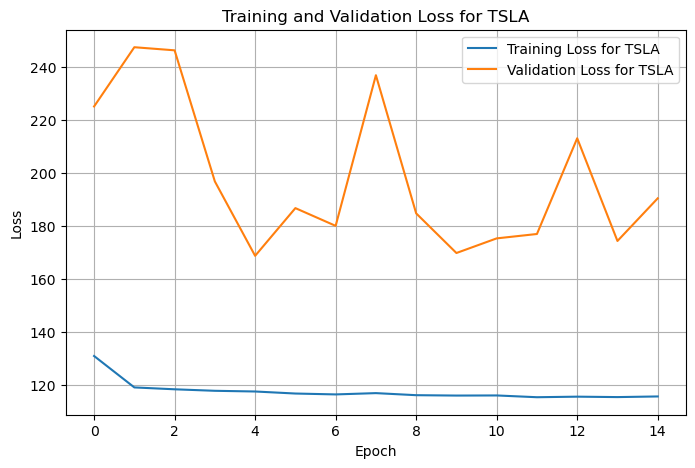

In [14]:
# Extracting loss and validation loss
train_loss_TSLA = history_final_TSLA.history['loss']
val_loss_TSLA = history_final_TSLA.history['val_loss']

epochs_range_TSLA = range(len(train_loss_TSLA))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range_TSLA, train_loss_TSLA, label='Training Loss for TSLA')
plt.plot(epochs_range_TSLA, val_loss_TSLA, label='Validation Loss for TSLA')
plt.title('Training and Validation Loss for TSLA')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RMSE for TSLA

In [15]:
y_pred_TSLA = final_model_TSLA.predict(X_test_TSLA_scaled)
test_rmse_TSLA = np.sqrt(mean_squared_error(y_test_TSLA, y_pred_TSLA))
print('RMSE for TSLA:', test_rmse_TSLA)

2151/2151 [==============================] - 6s 3ms/step
RMSE for TSLA: 12.693567103111292


## Train Model for AAPL

In [16]:
learning_rate = 0.001

scaler = MinMaxScaler()
X_train_AAPL, X_test_AAPL = df_AAPL_train[features], df_AAPL_test[features]
y_train_AAPL, y_test_AAPL = df_AAPL_train[target], df_AAPL_test[target]

X_train_AAPL_scaled = scaler.fit_transform(X_train_AAPL)
X_test_AAPL_scaled = scaler.transform(X_test_AAPL)

input_shape = (len(features),)

# Create sub-models for each moneyness category
module_itm = create_module(input_shape, [128,128,128], 3, 'elu')
module_atm = create_module(input_shape, [64, 128, 64], 3, 'relu')
module_otm = create_module(input_shape, [128], 1, 'relu')

# Compile each module
module_itm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
module_atm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
module_otm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')

# Train each module on its respective subset
module_itm.fit(X_itm_AAPL_scaled, y_itm_AAPL, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
module_atm.fit(X_atm_AAPL_scaled, y_atm_AAPL, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
module_otm.fit(X_otm_AAPL_scaled, y_otm_AAPL, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Define the combined model
input_layer = Input(shape=input_shape)
output_itm = module_itm(input_layer)
output_atm = module_atm(input_layer)
output_otm = module_otm(input_layer)

combined_output = Concatenate()([output_itm, output_atm, output_otm])
final_output = Dense(1, activation='linear')(combined_output)
final_model_AAPL = Model(inputs=input_layer, outputs=final_output)

# Compile the combined model
final_model_AAPL.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Fit the combined model to the full dataset (or a representative training set)
history_final_AAPL = final_model_AAPL.fit(X_train_AAPL_scaled, y_train_AAPL, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
1747/1747 [==============================] - 9s 4ms/step - loss: 99.7846 - val_loss: 43.7141
Epoch 2/50
1747/1747 [==============================] - 6s 4ms/step - loss: 31.1150 - val_loss: 40.9638
Epoch 3/50
1747/1747 [==============================] - 6s 4ms/step - loss: 29.8194 - val_loss: 41.6328
Epoch 4/50
1747/1747 [==============================] - 6s 4ms/step - loss: 29.2456 - val_loss: 48.3078
Epoch 5/50
1747/1747 [==============================] - 6s 4ms/step - loss: 28.9084 - val_loss: 43.4052
Epoch 6/50
1747/1747 [==============================] - 6s 4ms/step - loss: 28.6012 - val_loss: 41.4234
Epoch 7/50
1747/1747 [==============================] - 6s 4ms/step - loss: 28.3863 - val_loss: 37.9794
Epoch 8/50
1747/1747 [==============================] - 6s 4ms/step - loss: 28.1959 - val_loss: 40.5272
Epoch 9/50
1747/1747 [==============================] - 6s 4ms/step - loss: 27.9904 - val_loss: 38.3811
Epoch 10/50
1747/1747 [==============================] - 6s 4ms/

1858/1858 [==============================] - 5s 3ms/step - loss: 0.3474 - val_loss: 18.0211
Epoch 6/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.3182 - val_loss: 17.9330
Epoch 7/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.3019 - val_loss: 17.9097
Epoch 8/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2843 - val_loss: 17.9890
Epoch 9/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2769 - val_loss: 17.8782
Epoch 10/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2649 - val_loss: 17.9019
Epoch 11/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2570 - val_loss: 18.0903
Epoch 12/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2478 - val_loss: 17.9446
Epoch 13/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2417 - val_loss: 18.1064
Epoch 14/50
1858/1858 [==============================] - 5s 3ms/step - loss: 0.2

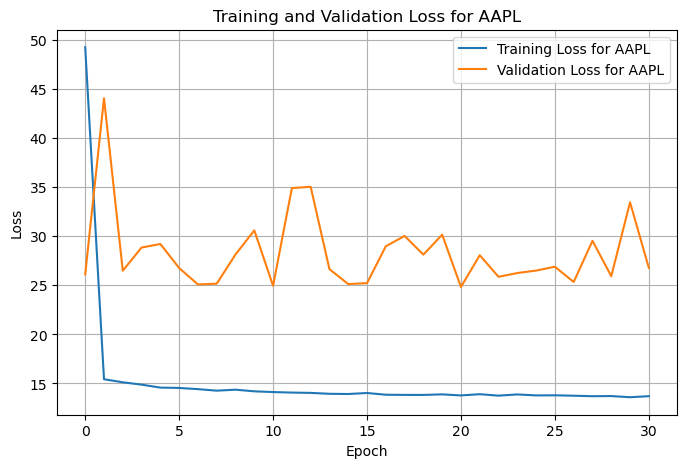

In [17]:
# Extracting loss and validation loss
train_loss_AAPL = history_final_AAPL.history['loss']
val_loss_AAPL = history_final_AAPL.history['val_loss']

epochs_range_AAPL = range(len(train_loss_AAPL))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range_AAPL, train_loss_AAPL, label='Training Loss for AAPL')
plt.plot(epochs_range_AAPL, val_loss_AAPL, label='Validation Loss for AAPL')
plt.title('Training and Validation Loss for AAPL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RMSE for AAPL

In [18]:
y_pred_AAPL = final_model_AAPL.predict(X_test_AAPL_scaled)
test_rmse_AAPL = np.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
print('RMSE for AAPL:', test_rmse_AAPL)

1066/1066 [==============================] - 3s 3ms/step
RMSE for AAPL: 3.541125359395983


## Train Model for NVDA

In [19]:
learning_rate = 0.001

scaler = MinMaxScaler()
X_train_NVDA, X_test_NVDA = df_NVDA_train[features], df_NVDA_test[features]
y_train_NVDA, y_test_NVDA = df_NVDA_train[target], df_NVDA_test[target]

X_train_NVDA_scaled = scaler.fit_transform(X_train_NVDA)
X_test_NVDA_scaled = scaler.transform(X_test_NVDA)

input_shape = (len(features),)

# Create sub-models for each moneyness category
module_itm = create_module(input_shape, [128,128,128], 3, 'elu')
module_atm = create_module(input_shape, [64, 128, 64], 3, 'relu')
module_otm = create_module(input_shape, [128], 1, 'relu')

# Compile each module
module_itm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
module_atm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
module_otm.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')

# Train each module on its respective subset
module_itm.fit(X_itm_NVDA_scaled, y_itm_NVDA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
module_atm.fit(X_atm_NVDA_scaled, y_atm_NVDA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
module_otm.fit(X_otm_NVDA_scaled, y_otm_NVDA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Define the combined model
input_layer = Input(shape=input_shape)
output_itm = module_itm(input_layer)
output_atm = module_atm(input_layer)
output_otm = module_otm(input_layer)

combined_output = Concatenate()([output_itm, output_atm, output_otm])
final_output = Dense(1, activation='linear')(combined_output)
final_model_NVDA = Model(inputs=input_layer, outputs=final_output)

# Compile the combined model
final_model_NVDA.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Fit the combined model to the full dataset (or a representative training set)
history_final_NVDA = final_model_NVDA.fit(X_train_NVDA_scaled, y_train_NVDA, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
3346/3346 [==============================] - 14s 4ms/step - loss: 1227.4943 - val_loss: 1504.5750
Epoch 2/50
3346/3346 [==============================] - 12s 4ms/step - loss: 896.1353 - val_loss: 1601.0978
Epoch 3/50
3346/3346 [==============================] - 12s 3ms/step - loss: 876.0663 - val_loss: 1508.8811
Epoch 4/50
3346/3346 [==============================] - 12s 3ms/step - loss: 864.4077 - val_loss: 1821.3181
Epoch 5/50
3346/3346 [==============================] - 13s 4ms/step - loss: 852.8129 - val_loss: 1641.4692
Epoch 6/50
3346/3346 [==============================] - 13s 4ms/step - loss: 847.3801 - val_loss: 1350.4865
Epoch 7/50
3346/3346 [==============================] - 12s 4ms/step - loss: 843.9732 - val_loss: 1388.7991
Epoch 8/50
3346/3346 [==============================] - 12s 4ms/step - loss: 836.4954 - val_loss: 1606.1942
Epoch 9/50
3346/3346 [==============================] - 13s 4ms/step - loss: 834.1115 - val_loss: 1552.4498
Epoch 10/50
3346/3346 [====

6900/6900 [==============================] - 36s 5ms/step - loss: 432.5413 - val_loss: 703.3654
Epoch 9/50
6900/6900 [==============================] - 36s 5ms/step - loss: 433.4214 - val_loss: 700.1241
Epoch 10/50
6900/6900 [==============================] - 36s 5ms/step - loss: 432.0304 - val_loss: 889.1140
Epoch 11/50
6900/6900 [==============================] - 32s 5ms/step - loss: 434.1501 - val_loss: 631.0456
Epoch 12/50
6900/6900 [==============================] - 31s 4ms/step - loss: 432.6372 - val_loss: 680.3149
Epoch 13/50
6900/6900 [==============================] - 31s 5ms/step - loss: 432.8771 - val_loss: 670.2618
Epoch 14/50
6900/6900 [==============================] - 31s 4ms/step - loss: 432.0909 - val_loss: 676.5604
Epoch 15/50
6900/6900 [==============================] - 37s 5ms/step - loss: 433.7485 - val_loss: 700.3364
Epoch 16/50
6900/6900 [==============================] - 36s 5ms/step - loss: 431.9131 - val_loss: 1004.7169
Epoch 17/50
6900/6900 [=================

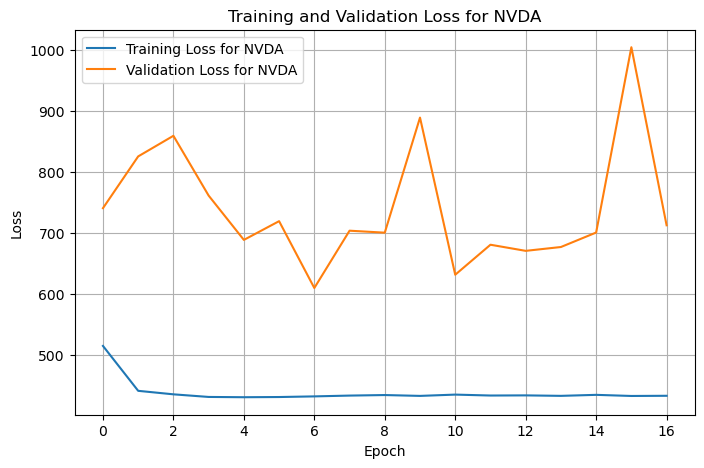

In [20]:
# Extracting loss and validation loss
train_loss_NVDA = history_final_NVDA.history['loss']
val_loss_NVDA = history_final_NVDA.history['val_loss']

epochs_range_NVDA = range(len(train_loss_NVDA))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range_NVDA, train_loss_NVDA, label='Training Loss for NVDA')
plt.plot(epochs_range_NVDA, val_loss_NVDA, label='Validation Loss for NVDA')
plt.title('Training and Validation Loss for NVDA')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RMSE for NVDA

In [21]:
y_pred_NVDA = final_model_NVDA.predict(X_test_NVDA_scaled)
test_rmse_NVDA = np.sqrt(mean_squared_error(y_test_NVDA, y_pred_NVDA))
print('RMSE for NVDA:', test_rmse_NVDA)

1917/1917 [==============================] - 6s 3ms/step
RMSE for NVDA: 24.175006041795665
